In [64]:
import matplotlib.pyplot as plt
import numpy as np

## Решение нелинейной краевой задачи для уравнения второго порядка методами стрельбы и квазилинеаризации

Получим численное решение следующей нелинейной краевой задачи.

#### $y'' + \frac{0,5}{1-0,5y}(y')^2=0, 0 < x <= 1$

#### $y(0)=1.5, y(1)=0$

### Общая постановка задачи

##### $y''=f(x,y,y'), 0<x<=1,$
##### $y(0)=Y_{0}, y(1)=Y_{1}$

In [65]:
Y0 = 1.5
Y1 = 0

### Метод стрельбы

Метод стрельбы для решения краевой задачи базируется на том, что имеются удобные способы численного решения задачи Коши, т. е. задачи

##### $y''=f(x,y,y'), 0<x<=1$
##### $y(0)=Y_{0}, y'(0)=\alpha$

В нашем случае: 
##### $y'_{1}(x)=y_2(x)$
##### $y'_{2}(x)=\frac{(0.5y_{2}'(x))^2}{0.5y_{1}(x)-1}$
##### $y_{1}(0)=Y_{0}, y_{2}(0)=\alpha$

In [66]:
def graph(independent_variable, dependent_variable, filename, title):
    """
    Build graph
    """

    plt.figure(figsize=[10, 4])
    plt.plot(independent_variable, dependent_variable, 'b-')

    plt.title(title)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')

    plt.savefig(filename)

In [67]:
def f(x,y):
    """
    ODE's right side
    """
    # Здесь y[0] — это y, а y[1] — это dy/dt
    return np.array([y[1], -(0.5 * y[1] * y[1]) / (1 - 0.5 * y[0])])


In [68]:
def runge_kutta_iter(y, x, tau, idx):
    """
    Применение метода Рунге-Кутты для решения задачи Коши
    """
    # Здесь y[idx] — это значение функции в точке x[idx]
    # tau — шаг интегрирования
    k1 = tau * f(x[idx], y[idx])
    k2 = tau * f(x[idx] + tau / 2, y[idx] + k1 / 2)
    k3 = tau * f(x[idx] + tau, y[idx] - k1 + 2 * k2)
    return y[idx] + (k1 + 4 * k2 + k3) / 6


def solve_runge_kutta(f,y0,x):
    """
    Решение системы ОДУ методом Рунге-Кутты
    """
    # Здесь x — это массив значений независимой переменной
    # y0 — начальное условие
    n = len(x)
    tau = x[1] - x[0]
    y = np.zeros((n, len(y0)))

    # Инициализация первого значения
    y[0] = y0

    for idx in range(n - 1):
        y[idx + 1] = runge_kutta_iter(y, x, tau, idx)

    return y


def solve_сauchy(f, Y0, alpha):
    """
    Решение задачи Коши методом Рунге-Кутты
    """
    # Здесь f — это функция, задающая правую часть ОДУ
    # y0 — начальное условие
    # alpha — значение параметра

    y0 = np.array([Y0, alpha])

    # 0 < x <= 1
    X = 1
    # Количество точек на периоде (0, X]
    points_num = 1001
    x = np.linspace(0, X, points_num)

    # Решение ОДУ методом Рунге-Кутты
    sol = solve_runge_kutta(f, y0, x)
    y = sol[:, 0]

    # Значение функции в точке x = 1, alpha
    y_1 = y[-1]

    return x, sol[:, 0], y_1


def solve_shooting(f, Y0, Y1, eps, alpha):
    """
    Solve problem using the Shooting method
    """
    # Numerical derivation step
    h = 1e-5

    while True:
        # Find y(1, alpha) and y(1, alpha + h)
        x, y, y_1_alpha = solve_сauchy(f, Y0, alpha)
        _, _, y_1_alpha_h = solve_сauchy(f, Y0, alpha + h)

        # F(alpha_n)
        F_alpha_n = y_1_alpha - Y1 

        # Stop if needed precision is achieved
        if abs(F_alpha_n) < eps:
            break
        
        # F(alpha_n + h)
        F_alpha_n_h = y_1_alpha_h - Y1

        # Numerical derivative
        F_alpha_n_der = (F_alpha_n_h - F_alpha_n) / h

        # Next alpha
        alpha -= F_alpha_n / F_alpha_n_der

    return x, y


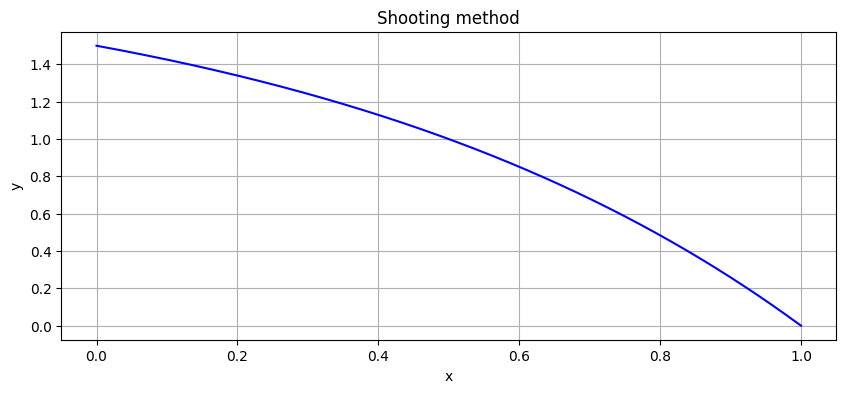

In [69]:
x, y = solve_shooting(f, Y0, Y1, 1e-6, 0.1)
graph(x, y, f"image/shooting.png", f"Shooting method")

<img src="image/shooting.png" alt="shooting"/>

### Метод квазилинеаризации

Рассмотрим нашу задачу и применим к ней метод квазилинеализации.

$$f(y^{m+1},y'^{m+1})=f(y^{m},y'^{m}) + \frac{\delta f}{\delta y}(y^{m},y'^{m})(y^{m+1}-y^{m})$$

$$f(y,y')=\frac{0.5y'^2}{0.5y-1}, \frac{\delta f}{\delta y}(y^m,y'^m)=-0.5(\frac{y'^m}{0.5y^m-1})^2$$

$$\frac{y_{k+1}^{m+1} - 2y_{k}^{m+1} + y_{k-1}^{m+1}}{h^2}=\frac{0.5((y')_{k}^{m+1})^2}{0.5y_{k}^{m+1}-1}$$

$$y_{0}^{m+1}=y(0)=Y_{0}, y_{N}^{m+1}=y(1)=0$$

$$\frac{y_{k+1}^{m+1} - 2y_{k}^{m+1} + y_{k-1}^{m+1}}{h^2}=\frac{0.5((y')_{k}^{m})^2}{0.5y_{k}^{m}-1} - \frac{0.25((y')_{k}^{m})^2}{(0.5y_{k}^{m}-1)^2}(y_{k}^{m+1}-y_{k}^{m})$$

###### $$\frac{y_{k+1}^{m+1} - 2y_{k}^{m+1} + y_{k-1}^{m+1}}{h^2}-\frac{0.5}{0.5y_{k}^{m}-1}(\frac{3y_{k+1}^{m}-4y_{k}^{m}+y_{k-1}^{m}}{2h})^2 + \frac{0.25}{(0.5y_{k}^{m}-1)^2}(\frac{3y_{k+1}^{m}-4y_{k}^{m}+y_{k-1}^{m}}{2h})^2(y_{k}^{m+1}-y_{k}^{m})=0$$

In [70]:
def quasilin_iter_get_matrix(y, h, N):
    """
    Build the matrix of the system
    """
    M = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        for j in range(N + 1):
            # y_{0}^{m+1} coeff
            if i == 0 and j == 0:
                M[i][j] = 1
            
            # y_{N}^{m+1} coeff
            elif i == N and j == N:
                M[i][j] = 1

            # y_{k}^{m+1} coeff
            elif i == j:
                deriv_sqr = pow((3 * y[i + 1] - 4 * y[i] + y[i - 1]) / (2 * h), 2)
                frac = 0.5 / (0.5 * y[i] - 1)
                M[i][j] = -2 / pow(h, 2) + pow(frac, 2) * deriv_sqr
            
            # y_{k-1}^{m+1} coeff or y_{k+1}^{m+1} coeff
            elif abs(i - j) == 1:
                M[i][j] = 1 / pow(h, 2)
            
            else:
                M[i][j] = 0

    return M

def quasilin_iter_get_right_side(y, h, N, Y0, Y1):
    """
    Build the right side of the system
    """
    right_side = np.zeros(N + 1)
    right_side[0] = Y0
    right_side[N] = Y1

    for i in range(1, N):
        deriv_sqr = pow((3 * y[i + 1] - 4 * y[i] + y[i - 1]) / (2 * h), 2)
    
        frac = 0.5 / (0.5 * y[i] - 1)
    
        right_side[i] = frac * deriv_sqr + pow(frac, 2) * deriv_sqr * y[i]

    return right_side

def quasilin_iter(y, h, N, Y0, Y1):
    """
    Perform one iteration using the common algorithm
    """
    # Build the matrix of the system
    M = quasilin_iter_get_matrix(y, h, N)
    
    # Build the right side of the system
    right_side = quasilin_iter_get_right_side(y, h, N, Y0, Y1)

    # Solve the system
    return np.linalg.solve(M, right_side)

import numpy as np

def solve_quasilin(Y0, Y1, eps, h, iteration_num):
    """
    Iterate until the desired accuracy is achieved
    """

    # Number of points on the interval [0;1]
    points_num = int(1 / h)

    # First approximation
    y_prev = np.full(points_num + 1, 1)

    for _ in range(iteration_num):
        # Compute current iteration result
        y_cur = quasilin_iter(y_prev, h, points_num, Y0, Y1)

        # Check for convergence
        if np.max(np.abs(y_cur - y_prev)) < eps:
            break

        # Update for next iteration
        y_prev = y_cur

    x = np.linspace(0, 1, points_num + 1)
    return x, y_cur


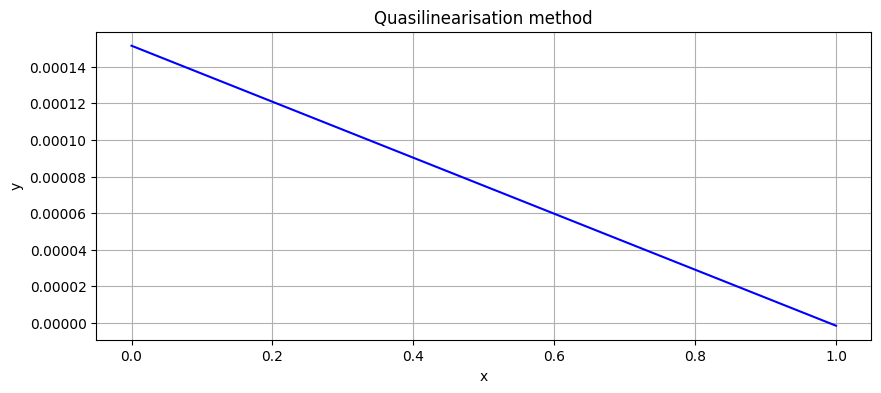

In [71]:
x, y = solve_quasilin(Y0, Y1, 1e-3, 0.01, 100)
graph(x, y, f"image/quasilin.png", f"Quasilinearisation method")

<img src="image/quasilin.png" alt="quasilin"/>